# Goal of this script is to analysis 4DSTEM with large beam/small conv angle and map electric field and polarization

In [1]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import scipy

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import scipy.io
import time
import glob,os
import cv2
from scipy import optimize
from pylab import *

import imutils
import cv2

## Step1: Calculate reference COM from blanks scan x3

262.05574552741274 253.65335212540296


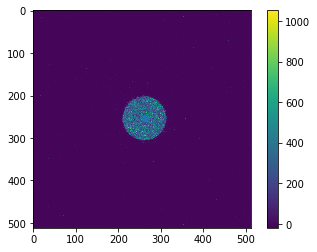

In [72]:
RefPath = '/srv/home/chenyu/DEbackup/012019/C2/'
RefName = 'S0'
rx = 100;
ry = 100;

sample = np.load(RefPath+'npy/'+RefName+'_'+format(5000,'05')+'.npy')
kx,ky = sample.shape[0:2]
kx = np.linspace(0,kx-1,kx)
ky = np.linspace(0,ky-1,ky)
weights_x, weights_y = np.meshgrid(kx,ky)

COM_x = np.average(weights_x,weights = sample)
COM_y = np.average(weights_y,weights = sample)
           
plt.imshow(sample)
plt.colorbar()
plt.scatter(COM_x,COM_y)

print(COM_x,COM_y)

In [14]:
RefPath = '/srv/home/chenyu/DEbackup/012019/C3/'
RefPath2 = '/srv/home/chenyu/DEbackup/012019/C2/'
RefPath3 = '/srv/home/chenyu/DEbackup/012019/C1/'
RefName = 'S0'
rx = 100
ry = 100

sample = np.load(RefPath+'npy/'+RefName+'_'+format(1,'05')+'.npy')
kx,ky = sample.shape[0:2]
kx = np.linspace(0,kx-1,kx)
ky = np.linspace(0,ky-1,ky)
weights_x, weights_y = np.meshgrid(kx,ky)

COM = np.zeros((rx,ry,2))

for ix in range(rx):
    for iy in range(ry):
        nSample = ix*rx+iy+1
        sample = np.load(RefPath+'npy/'+RefName+'_'+format(nSample,'05')+'.npy')
        sample = sample + np.load(RefPath2+'npy/'+RefName+'_'+format(nSample,'05')+'.npy')
#         sample = sample + np.load(RefPath3+'npy/'+RefName+'_'+format(nSample,'05')+'.npy')
        COM[ix,iy,0] = np.average(weights_x,weights = sample)
        COM[ix,iy,1] = np.average(weights_y,weights = sample)
        
        if ix % 10 == 0 and iy == 0:
            print("Finished line %d " % (ix))

Finished line 0 
Finished line 10 
Finished line 20 
Finished line 30 
Finished line 40 
Finished line 50 
Finished line 60 
Finished line 70 
Finished line 80 
Finished line 90 


0.3798109938175657


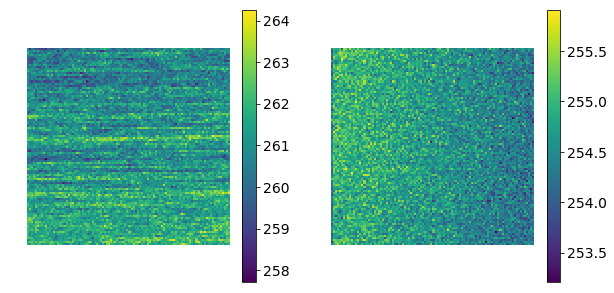

In [3]:
COM = np.load('/srv/home/chenyu/DEbackup/012019/BlankCOM.npy')

fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
plt.imshow(COM[2:-1,:,0])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')

fig.add_subplot(122)
plt.imshow(COM[2:-1:,:,1])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.axis('off')

print(np.std(COM[2:-1,:,1]))

86 77 52


NameError: name 'COM_x' is not defined

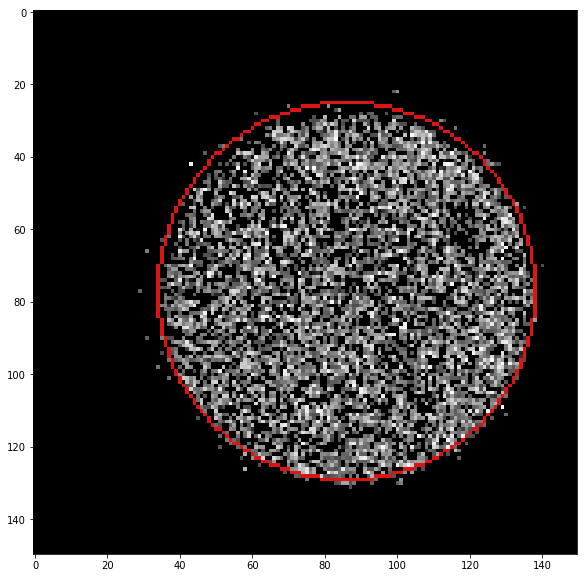

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, disk

ExpPath = '/srv/home/chenyu/DEbackup/012019/S2/'
ExpName = 'S2'
rx = 100;
ry = 100;


COM = np.zeros((rx,ry,2))
BF = np.zeros((rx,ry))
Accumulated = np.zeros((512,512))

for ix in range(1,rx):
    
    for iy in range(ry):
        nSample = ix*rx+iy+1

        sample = np.load(ExpPath+'npy/'+ExpName+'_'+format(nSample,'05')+'.npy')
        Accumulated = Accumulated + sample
        sample = sample[175:325,175:325]

        # Step 1: roughly detect position of zero disk, filter out all intensity outside the disk

        bw = 1.0*(sample > 75)
        selem = disk(5)
        bw2 = closing(bw, selem)
        edges = canny(bw2)

        sample = sample*bw
        sample = sample.astype('uint8')
        temp = edges.astype('uint8')
        # plt.imshow(sample)
        # plt.colorbar()

        image = sample

        # Detect two radii
        # hough_radii = np.arange(175,190,1)
        hough_radii = np.arange(50,55,1)
        hough_res = hough_circle(temp, hough_radii)

        # Select the most prominent 5 circles
        accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                                   total_num_peaks=5)
#         print(cx,cy,radii)

        cx = int(np.average(cx))
        cy = int(np.average(cy))
        radii = int(np.average(radii))

        # create a slightly larger mask in case Hough circle detection is not accurate
        mask = create_circular_mask(sample.shape[0],sample.shape[1],center=[cx,cy], radius=radii+5)

        # Step 2: calculate new center of mass
        kx,ky = sample.shape[0:2]
        kx = np.linspace(0,kx-1,kx)
        ky = np.linspace(0,ky-1,ky)
        weights_x, weights_y = np.meshgrid(kx,ky)
        COM[ix,iy,0] = np.average(weights_x,weights = sample*mask) + 175
        COM[ix,iy,1] = np.average(weights_y,weights = sample*mask) + 175
        
        # Step 3: meanwhile calculate BF using center disk
        BF[ix,iy] = np.sum(sample*mask)


# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
image = color.gray2rgb(image)
cx = int(np.average(cx))
cy = int(np.average(cy))
radii = int(np.average(radii))

print(cx,cy,radii)
circy, circx = circle_perimeter(cy,cx,radii)
image[circy, circx] = (220, 20, 20)


ax.imshow(image*color.gray2rgb(mask), cmap=plt.cm.gray)
plt.scatter(COM_x,COM_y)
plt.show()

print(cx,cy,radii)
           


In [11]:
ref = np.load('/srv/home/chenyu/DEbackup/012019/BlankCOM.npy')
COM = COM - ref
np.save('/srv/home/chenyu/DEbackup/012019/S2/COM.npy',COM)
np.save('/srv/home/chenyu/DEbackup/012019/S2/BF.npy',BF)
np.save('/srv/home/chenyu/DEbackup/012019/S2/Accumulated.npy',Accumulated)

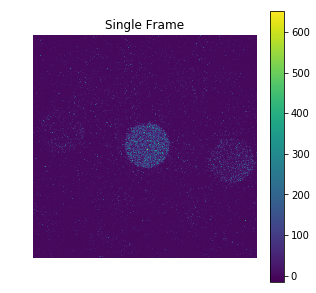

In [41]:
# View of a random single frame
sample = np.load(ExpPath+'npy/'+ExpName+'_'+format(4500,'05')+'.npy')
fig, axes = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
im = axes.imshow(sample)
axes.axis('off')
axes.set_title('Single Frame')
fig.colorbar(im,ax=axes)

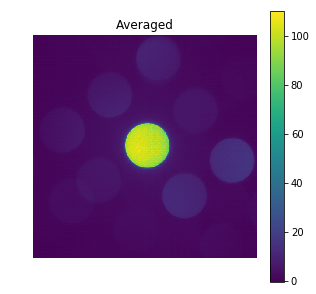

In [42]:
# View of accumulated diffraction pattern
fig, axes = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
im = axes.imshow(Accumulated/100/99)
axes.axis('off')
axes.set_title('Averaged')
fig.colorbar(im,ax=axes)

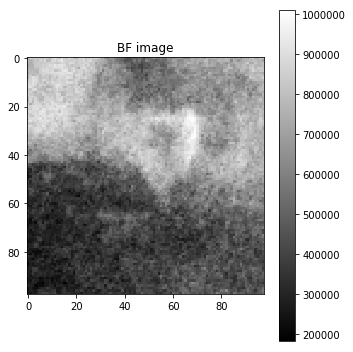

In [177]:
fig, axes = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
im = axes.imshow(np.flipud(np.transpose(BF[1:-1,1:-1])), cmap=plt.cm.gray)
# axes.axis('off')
axes.set_title('BF image')
fig.colorbar(im,ax=axes)

fig.tight_layout()

plt.show()
# After transpose and flipud, the image configuration matches with experiment HAADF on Titan

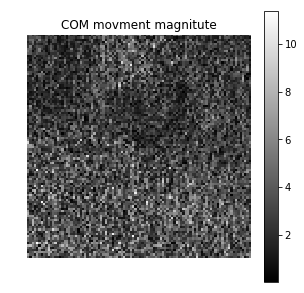

In [47]:
COM = np.load('/srv/home/chenyu/DEbackup/012019/S2/COM.npy')
COM_mag = np.sqrt(np.square(COM[:,:,0])+np.square(COM[:,:,1]))

fig, axes = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
im=axes.imshow(np.flipud(np.transpose(COM_mag[1:-1,1:-1])), cmap=plt.cm.gray)
axes.axis('off')
axes.set_title('COM movment magnitute')
fig.colorbar(im,ax=axes)

# plt.imshow(np.flipud(np.transpose(np.sqrt(COM_mag[1:-1,:]))))
# # plt.imshow(np.flipud(np.transpose(COM[1:-1,:,0])))
# plt.colorbar()

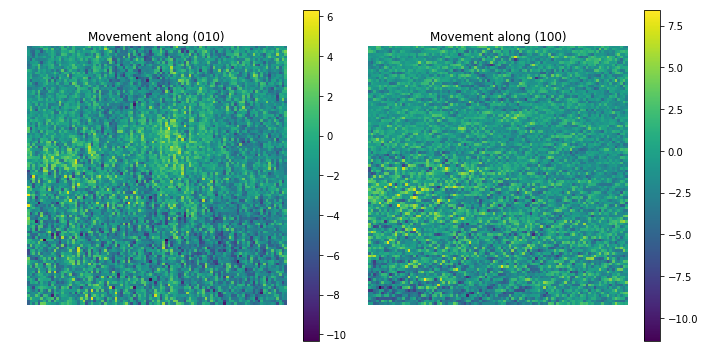

In [64]:
# COM_x correspond to projection on <100> direction that is close to x axis
COM_x = COM[:,:,0]*np.cos(np.deg2rad(-7.8))+COM[:,:,1]*np.sin(np.deg2rad(-7.8))
COM_y = - COM[:,:,0]*np.sin(np.deg2rad(-7.8))+COM[:,:,1]*np.cos(np.deg2rad(-7.8))

fig, axes = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
ax = axes.ravel()

im0 = ax[0].imshow(np.flipud(np.transpose(COM_x[1:-1,1:-1])))
ax[0].axis('off')
ax[0].set_title('Movement along (010)')
fig.colorbar(im0,ax=ax[0])

im1 = ax[1].imshow(np.flipud(np.transpose(COM_y[1:-1,1:-1])))
ax[1].axis('off')
ax[1].set_title('Movement along (100)')
fig.colorbar(im1,ax=ax[1])


fig.tight_layout()

plt.show()

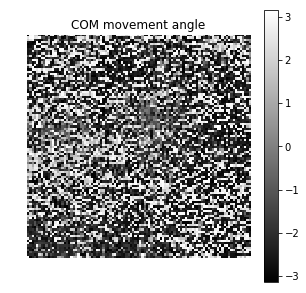

In [44]:
COM = np.load('/srv/home/chenyu/DEbackup/012019/S2/COM.npy')
COM_ang = np.arctan2(COM[:,:,1],COM[:,:,0])

fig, axes = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
im=axes.imshow(np.flipud(np.transpose(COM_ang[1:-1,1:-1])), cmap=plt.cm.gray)
axes.axis('off')
axes.set_title('COM movement angle')
fig.colorbar(im,ax=axes)

## Calculate diffraction pattern for substrate and film

In [2]:
ExpPath = '/srv/home/chenyu/DEbackup/012019/S2/'
ExpName = 'S2'
rx = 100;
ry = 100;

STO_Accumulated = zeros((512,512))
PZT_Accumulated = zeros((512,512))

for ix in range(1,rx):
    if ix < 65 and ix > 60:
        for iy in range(ry):
            
            nSample = ix*rx+iy+1
            sample = np.load(ExpPath+'npy/'+ExpName+'_'+format(nSample,'05')+'.npy')
            PZT_Accumulated = PZT_Accumulated + sample
            
    if ix > 80 and ix < 85:
        for iy in range(ry):
            
            nSample = ix*rx+iy+1
            sample = np.load(ExpPath+'npy/'+ExpName+'_'+format(nSample,'05')+'.npy')
            STO_Accumulated = STO_Accumulated + sample



/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


[]

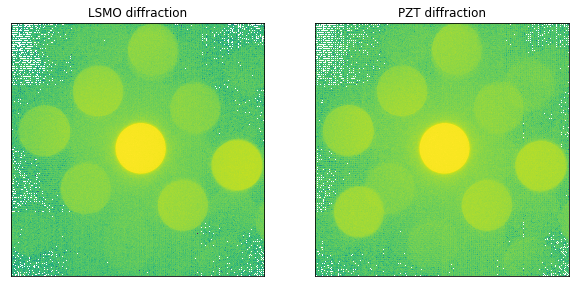

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(log(STO_Accumulated))
axes[0].set_title('LSMO diffraction')
axes[1].imshow(log(PZT_Accumulated))
axes[1].set_title('PZT diffraction')
axes[0].set_xticks([])
axes[1].set_xticks([])
axes[0].set_yticks([])
axes[1].set_yticks([])

## Calculate polarization using conjugate diffraction disk pairs
### Left and right pair

[]

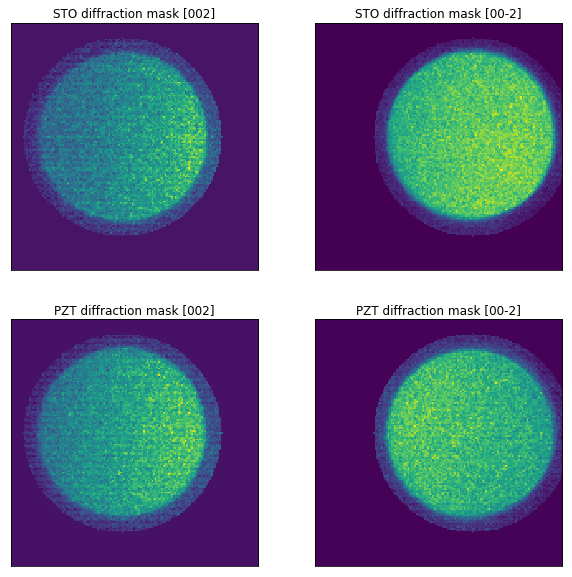

In [246]:
cy1 = 69
cx1 = 67
radii = 50

cy2 = 69
cx2 = 95
radii = 50

mask1 = create_circular_mask(patch1.shape[0],patch1.shape[1],center=[cx1,cy1],radius = radii+10)
mask2 = create_circular_mask(patch2.shape[0],patch2.shape[1],center=[cx2,cy2],radius = radii+10)

fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes[0,0].imshow(STO_Accumulated[150:300,0:150]*mask1)
axes[0,0].set_title('STO diffraction mask [002]')
axes[0,1].imshow(STO_Accumulated[220:370,361:511]*mask2)
axes[0,1].set_title('STO diffraction mask [00-2]')
axes[1,0].imshow(PZT_Accumulated[150:300,0:150]*mask1)
axes[1,0].set_title('PZT diffraction mask [002]')
axes[1,1].imshow(PZT_Accumulated[220:370,361:511]*mask2)
axes[1,1].set_title('PZT diffraction mask [00-2]')

axes[0,0].set_xticks([])
axes[0,0].set_yticks([])
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])
axes[1,0].set_xticks([])
axes[1,0].set_yticks([])
axes[1,1].set_xticks([])
axes[1,1].set_yticks([])

In [231]:
# Use the selected circle, apply mask on each frame and calculate current flow between the two disks

# mask will be shared for all frames, use a radius that is slightly larger than disk
mask1 = create_circular_mask(patch1.shape[0],patch1.shape[1],center=[cx1,cy1],radius = radii+10)
mask2 = create_circular_mask(patch2.shape[0],patch2.shape[1],center=[cx2,cy2],radius = radii+10)

# create array to save polar signal
polar_map = np.zeros((rx,ry))

for ix in range(1,rx):    
    for iy in range(ry):
        nSample = ix*rx+iy+1
        sample = np.load(ExpPath+'npy/'+ExpName+'_'+format(nSample,'05')+'.npy')
        patch1 = sample[150:300,0:150]
        patch2 = sample[220:370,361:511]
        polar_map[ix,iy] = np.sum(patch1*mask1)/np.sum(mask1) - np.sum(patch2*mask2)/np.sum(mask2)
        


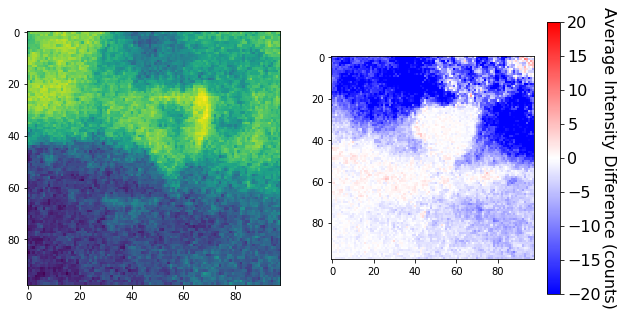

In [232]:
# Display final results

fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(np.flipud(np.transpose(BF[1:-1,1:-1])))
im = axes[1].imshow(np.flipud(np.transpose(polar_map[1:-1,1:-1])),cmap=plt.get_cmap('bwr'),clim=[-20,20])

cbar = fig.colorbar(im,ax=axes[1])
cbar.ax.set_ylabel('Average Intensity Difference (counts)',fontsize=16,rotation = 270)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 15

## Top and bottom pair

Text(0.5, 1.0, 'PZT diffraction mask2')

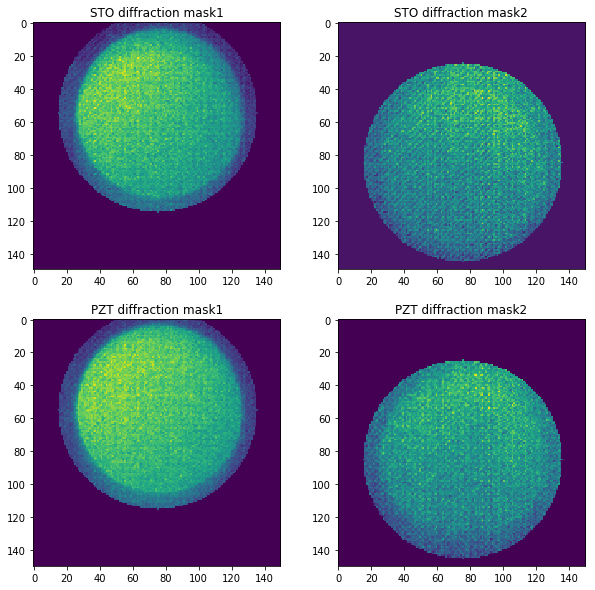

In [196]:
cy1 = 55
cx1 = 75
radii = 50

cy2 = 85
cx2 = 75
radii = 50

mask1 = create_circular_mask(patch1.shape[0],patch1.shape[1],center=[cx1,cy1],radius = radii+10)
mask2 = create_circular_mask(patch2.shape[0],patch2.shape[1],center=[cx2,cy2],radius = radii+10)

fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes[0,0].imshow(STO_Accumulated[0:150,210:360]*mask1)
axes[0,0].set_title('STO diffraction mask1')
axes[0,1].imshow(STO_Accumulated[362:512,160:310]*mask2)
axes[0,1].set_title('STO diffraction mask2')
axes[1,0].imshow(PZT_Accumulated[0:150,210:360]*mask1)
axes[1,0].set_title('PZT diffraction mask1')
axes[1,1].imshow(PZT_Accumulated[362:512,160:310]*mask2)
axes[1,1].set_title('PZT diffraction mask2')

In [244]:
# Use the selected circle, apply mask on each frame and calculate current flow between the two disks

# mask will be shared for all frames, use a radius that is slightly larger than disk
mask1 = create_circular_mask(patch1.shape[0],patch1.shape[1],center=[cx1,cy1],radius = radii+10)
mask2 = create_circular_mask(patch2.shape[0],patch2.shape[1],center=[cx2,cy2],radius = radii+10)

# create array to save polar signal
polar_map = np.zeros((rx,ry))

for ix in range(1,rx):    
    for iy in range(ry):
        nSample = ix*rx+iy+1
        sample = np.load(ExpPath+'npy/'+ExpName+'_'+format(nSample,'05')+'.npy')
        patch1 = sample[0:150,210:360]
        patch2 = sample[362:512,160:310]
        polar_map[ix,iy] = np.sum(patch1*mask1)/np.sum(mask1) - np.sum(patch2*mask2)/np.sum(mask2)
        


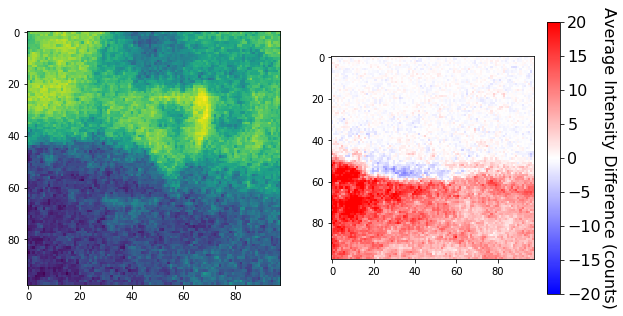

In [245]:
# Display final results
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(np.flipud(np.transpose(BF[1:-1,1:-1])))
im = axes[1].imshow(np.flipud(np.transpose(polar_map[1:-1,1:-1])),cmap=plt.get_cmap('bwr'),clim=[-20,20])

cbar = fig.colorbar(im,ax=axes[1])
cbar.ax.set_ylabel('Average Intensity Difference (counts)',fontsize=16,rotation = 270)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 15

In [223]:
print(np.sum(mask2))

11109


## Aux Functions

In [5]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask